Doing exp 2 on new data again, but with numeric encoding and pca

In [ ]:
from google.colab import drive
drive.mount('/content/drive') # for google colab to access google drive
!pip install sentence-transformers
from sentence_transformers import SentenceTransformer

import xml.etree.ElementTree as ET
import os
import pandas as pd
from sklearn.utils import shuffle
import calendar
import numpy
import re
from sklearn.model_selection import train_test_split

# Path to your XML files
xml_folder = '/content/drive/My Drive/Colab Notebooks/Independent Study/Data/xml'

# List all XML files in the directory
xml_files = [f for f in os.listdir(xml_folder) if f.endswith('.xml')]

# Initialize an empty list to store data from all XML files
all_data = []

# Loop through each file in the XML directory
for file_name in xml_files:
    file_path = os.path.join(xml_folder, file_name)
    try:
        tree = ET.parse(file_path)
        root = tree.getroot()

        # Extract data from each <TestbedMonJun14Flows> element (adjust tag as needed)
        for flow in root.findall('./*'):  # Check if this tag needs to be adjusted
            flow_data = {
                'appName': flow.find('appName').text if flow.find('appName') is not None else None,
                'totalSourceBytes': flow.find('totalSourceBytes').text if flow.find('totalSourceBytes') is not None else None,
                'totalDestinationBytes': flow.find('totalDestinationBytes').text if flow.find('totalDestinationBytes') is not None else None,
                'totalSourcePackets': flow.find('totalSourcePackets').text if flow.find('totalSourcePackets') is not None else None,
                'direction': flow.find('direction').text if flow.find('direction') is not None else None,
                'source': flow.find('source').text if flow.find('source') is not None else None,
                'protocolName': flow.find('protocolName').text if flow.find('protocolName') is not None else None,
                'sourcePort': flow.find('sourcePort').text if flow.find('sourcePort') is not None else None,
                'destination': flow.find('destination').text if flow.find('destination') is not None else None,
                'destinationPort': flow.find('destinationPort').text if flow.find('destinationPort') is not None else None,
                'startDateTime': flow.find('startDateTime').text if flow.find('startDateTime') is not None else None,
                'stopDateTime': flow.find('stopDateTime').text if flow.find('stopDateTime') is not None else None,
                'Tag': flow.find('Tag').text if flow.find('Tag') is not None else None
            }
            all_data.append(flow_data)
    except ET.ParseError as pe:
        print(f"Error parsing {file_name}: {pe}")

# Convert list to DataFrame
df = pd.DataFrame(all_data)

# Display the DataFrame
print(df.head())


def create_balanced_batches(df, batch_size=100, min_attacks=4):
    # Separate attack and normal instances
    attacks = df[df['Tag'] == 'Attack']
    normals = df[df['Tag'] == 'Normal']

    # Shuffle both datasets
    attacks = shuffle(attacks)
    normals = shuffle(normals)

    batches = []
    num_batches = len(df) // batch_size

    for _ in range(num_batches):
        if len(attacks) >= min_attacks and len(normals) >= (batch_size - min_attacks):
            # Take min_attacks from attacks and fill the rest with normals
            batch = pd.concat([
                attacks.iloc[:min_attacks],
                normals.iloc[:(batch_size - min_attacks)]
            ])
            # Shuffle the batch to mix attacks and normals
            batch = shuffle(batch)
            batches.append(batch)

            # Remove selected samples
            attacks = attacks.iloc[min_attacks:]
            normals = normals.iloc[batch_size - min_attacks:]
        else:
            break  # Break if there aren't enough samples to fill a batch as specified

    # Add remaining samples to a final batch if not empty
    if not attacks.empty or not normals.empty:
        remaining_batch = pd.concat([attacks, normals])
        remaining_batch = shuffle(remaining_batch)
        batches.append(remaining_batch)

    # Concatenate all batches back into a single DataFrame
    new_df = pd.concat(batches).reset_index(drop=True)
    return new_df

# Assuming df is your original DataFrame
new_df = create_balanced_batches(df)

#see how many duplicate entries there are in new_df
duplicates = new_df.duplicated().sum()
original_len = len(new_df)
print(f"Number of duplicate entries: {duplicates}")
print(f"Original DataFrame length: {original_len}")
print(original_len-duplicates)

#drop the duplicates
new_df = new_df.drop_duplicates()
print(new_df.shape)

# Calculate the correlation matrix as you have already done
tag_mapping = {'Normal': 0, 'Attack': 1}
new_df['Tag'] = new_df['Tag'].map(tag_mapping)


# Function to convert numeric month and weekday to names
def process_LLM_datetime(df):
    df = df.copy()  # Create a copy of the DataFrame to avoid modifying the original
    to_check = ['month', 'weekday']
    for col in to_check:
        if col == 'month':
            df[col] = df[col].apply(lambda x: calendar.month_name[x])
        elif col == 'weekday':
            df[col] = df[col].apply(lambda x: calendar.day_name[x])
    return df

# Convert to datetime if not already done
new_df['startDateTime'] = pd.to_datetime(df['startDateTime'])
new_df['stopDateTime'] = pd.to_datetime(df['stopDateTime'])

# Extract date and time components from startDateTime
new_df['year'] = new_df['startDateTime'].dt.year
new_df['month'] = new_df['startDateTime'].dt.month
new_df['day'] = new_df['startDateTime'].dt.day
new_df['weekday'] = new_df['startDateTime'].dt.weekday
new_df['dayofyear'] = new_df['startDateTime'].dt.dayofyear
new_df['hour'] = new_df['startDateTime'].dt.hour
new_df['minute'] = new_df['startDateTime'].dt.minute
new_df['second'] = new_df['startDateTime'].dt.second

# Calculate duration in seconds
new_df['duration_seconds'] = (new_df['stopDateTime'] - new_df['startDateTime']).dt.total_seconds()

#remove start and stop features
new_df = new_df.drop(['startDateTime', 'stopDateTime'], axis=1)

# Create a copy for LLM processing
df_llm = new_df.copy()

# Apply the process_LLM_datetime function to the df_llm copy
df_llm = process_LLM_datetime(df_llm)

print("\nLLM Processed DataFrame (df_llm):")
print(df_llm.head())

X_llm = df_llm.drop('Tag', axis=1)
y_llm = df_llm['Tag']

X_train_llm, X_test_llm, y_train_llm, y_test_llm = train_test_split(X_llm, y_llm, test_size=0.3, random_state=42)

print(X_train_llm.shape)
print(X_test_llm.shape)
print(y_train_llm.shape)
print(y_test_llm.shape)






Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.3/245.3 kB 16.4 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


Error parsing TestbedThuJun17-1Flows.xml: not well-formed (invalid token): line 3135760, column 209
             appName totalSourceBytes totalDestinationBytes  \
0        Unknown_UDP            16076                     0   
1  HTTPImageTransfer              384                     0   
2                DNS              171                   642   
3  HTTPImageTransfer              384                     0   
4  HTTPImageTransfer              186                   128   

  totalSourcePackets direction         source protocolName sourcePort  \
0                178       L2R  192.168.5.122       udp_ip       5353   
1                  6       L2R  192.168.2.111       tcp_ip       4435   
2                  2       L2L  192.168.4.119       udp_ip       4428   
3                  6       L2R  192.168.4.119       tcp_ip       3639   
4                  2       L2R  192.168.4.119       tcp_ip       3641   

       destination destinationPort        startDateTime         stopDateTime  \
0 

In [ ]:
# prompt: We need to see the ratio of target variables in the test set

# Calculate the ratio of target variables in the test set
target_ratio = y_test_llm.value_counts(normalize=True)
print("Ratio of target variables in the test set:\n", target_ratio)


Ratio of target variables in the test set:
 Tag
0    0.966532
1    0.033468
Name: proportion, dtype: float64


In [ ]:
embeddings_train = X_train_llm.copy()
embeddings_test = X_test_llm.copy()

def textualize(X_train, X_test, y_train=None, add_label=False):
    # Helper function to convert a data row to textual format
    def to_textual(data, labels=None):
        textual_data = []
        for index, row in enumerate(data.values):
            row_textual = [f"{col}: {val}" for col, val in zip(data.columns, row)]
            if add_label and labels is not None:
                row_textual.append(f"label: {labels.iloc[index]}")
            textual_data.append(' '.join(row_textual))
        return textual_data

    train_x_textual = to_textual(X_train, y_train if add_label else None)
    test_x_textual = to_textual(X_test)  # Labels typically not needed for test data in description generation

    return train_x_textual, test_x_textual

train_textual, test_textual = textualize(embeddings_train, embeddings_test)
print(train_textual[0])
print(test_textual[0])
print(len(train_textual), y_train_llm.shape)
print(len(test_textual), y_test_llm.shape)


appName: WindowsFileSharing totalSourceBytes: 247 totalDestinationBytes: 0 totalSourcePackets: 1 direction: L2L source: 192.168.3.115 protocolName: udp_ip sourcePort: 138 destination: 192.168.3.255 destinationPort: 138 year: 2010 month: June day: 12 weekday: Saturday dayofyear: 163 hour: 11 minute: 57 second: 46 duration_seconds: 135.0
appName: HTTPWeb totalSourceBytes: 864 totalDestinationBytes: 1376 totalSourcePackets: 9 direction: L2R source: 192.168.2.106 protocolName: tcp_ip sourcePort: 2351 destination: 192.150.18.200 destinationPort: 80 year: 2010 month: June day: 16 weekday: Wednesday dayofyear: 167 hour: 12 minute: 18 second: 57 duration_seconds: 5.0
1222641 (1222641,)
523989 (523989,)


In [ ]:

def process_all_numbers(text):
    def f(match):
        num = match.group(0)
        integer_part = match.group(1)
        integer_length = len(integer_part)
        decimal_part = match.group(3)
        decimal_length = len(decimal_part) if decimal_part else 0

        if decimal_part:
            prefix = f'<sn>{integer_length}.{decimal_length}<mn>'
        else:
            prefix = f'<sn>{integer_length}<mn>'

        return prefix + num + '<en>'

    pattern = r'(\d+)(\.(\d+))?'
    return re.sub(pattern, f, text)

train_processed_text = []
test_processed_text = []

for string in train_textual:
    processed_string = process_all_numbers(string)
    train_processed_text.append(processed_string)

for string in test_textual:
    processed_string = process_all_numbers(string)
    test_processed_text.append(processed_string)

print("Before Process:")
print(train_textual[0])



print("\nPost-Processed String:")
print(train_processed_text[0])

def embed_data(train_text, test_text):
    # embed data with LLM
    llm_model = SentenceTransformer(r"sentence-transformers/paraphrase-MiniLM-L6-v2")
    embeddings_train = llm_model.encode(train_text, show_progress_bar=True, normalize_embeddings=True)
    embeddings_test = llm_model.encode(test_text, show_progress_bar=True, normalize_embeddings=True)
    return embeddings_train, embeddings_test
embeddings_train, embeddings_test = embed_data(train_processed_text, test_processed_text)
print(embeddings_train.shape)
print(embeddings_test.shape)

In [ ]:
def embed_data(train_text, test_text):
    # embed data with LLM
    llm_model = SentenceTransformer(r"sentence-transformers/paraphrase-MiniLM-L6-v2")
    embeddings_train = llm_model.encode(train_text, show_progress_bar=True, normalize_embeddings=True)
    embeddings_test = llm_model.encode(test_text, show_progress_bar=True, normalize_embeddings=True)
    return embeddings_train, embeddings_test
embeddings_train, embeddings_test = embed_data(train_textual, test_textual)
print(embeddings_train.shape)
print(embeddings_test.shape)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/38208 [00:00<?, ?it/s]

Batches:   0%|          | 0/16375 [00:00<?, ?it/s]

(1222641, 384)
(523989, 384)


RUN ON CPU RUNTIME

In [ ]:
from sklearn.decomposition import PCA

def apply_pca(X_train, X_test, variance_threshold=0.95):
    # Fit PCA on training data
    pca = PCA(n_components=20)
    pca.fit(X_train)

    # Transform both train and test data
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)

    n_components = pca.n_components_
    print(f"Number of components selected: {n_components}")
    print(f"Cumulative explained variance ratio: {pca.explained_variance_ratio_.sum():.4f}")

    return X_train_pca, X_test_pca, n_components

# Apply PCA to embeddings
embeddings_train_pca, embeddings_test_pca, n_components = apply_pca(embeddings_train, embeddings_test)

print(embeddings_train_pca.shape)
print(embeddings_test_pca.shape)
print(f"Number of components selected: {n_components}")

Number of components selected: 20
Cumulative explained variance ratio: 0.8982
(1222641, 20)
(523989, 20)
Number of components selected: 20


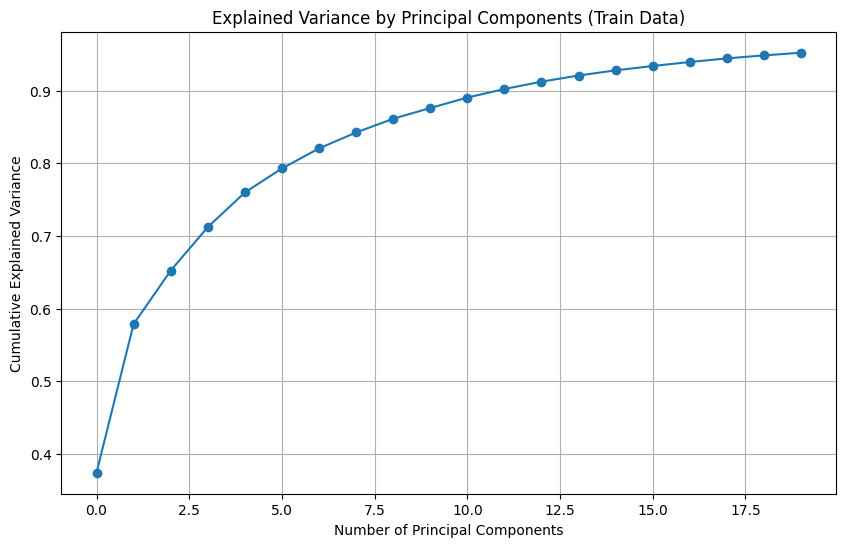

Top features for each principal component (Train Data):
    PC1  PC2  PC3  PC4  PC5  PC6  PC7  PC8  PC9  PC10  PC11  PC12  PC13  PC14  \
0   75    2  327  310  178   21  234  379  303   208   254   299   301     3   
1  259  147   41  295    0  226  297  229  356   293   205   153   354   162   
2  347   74  383  237  197   13  132  282  239   144   219     8    81   192   
3  341  123  373  107  238  260    0  110  326    89   120    79    50   292   
4  376  109  137  349    3  132  271  356  122   218   333     5   288   226   
5  314   91  374  352  107  246   14   49  108   283   193   172   194   245   
6  240  210   34   65  160  188   10  196   12   336   331   346    96   190   
7  202   36  182  198  105  229  308  235   21     5   194   185   263   215   
8  316  155  188  136   92  202  309  206   44   115    96    30    83   122   
9  177  184  379   40  217   76   97    3  140   360   251   293   216   274   

   PC15  PC16  PC17  PC18  PC19  PC20  
0   158   250   215   

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Step 2: Apply PCA on the training data
pca = PCA(n_components=20)  # Adjust the number of components or the variance ratio
principal_components_train = pca.fit_transform(embeddings_train)
X_train_pca = principal_components_train

# Step 3: Analyze explained variance for the training data
explained_variance_train = pca.explained_variance_ratio_
cumulative_variance_train = np.cumsum(explained_variance_train)

# Plot the explained variance for the training data
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance_train, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Principal Components (Train Data)')
plt.grid()
plt.show()

# Step 4: Analyze loading scores for the training data
loading_scores_train = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(len(pca.components_))])
top_features_train = loading_scores_train.apply(lambda x: np.abs(x).nlargest(10).index, axis=0)  # Top 10 features for each PC

print("Top features for each principal component (Train Data):\n", top_features_train)


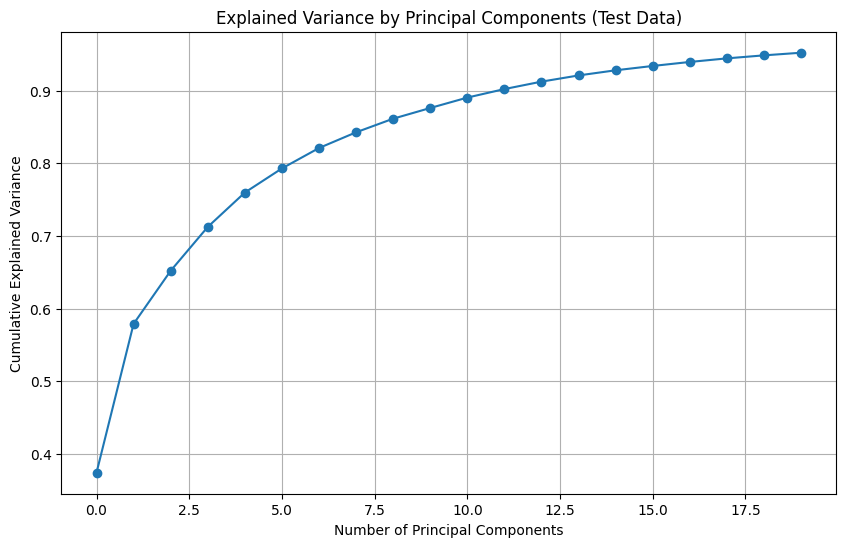

Top features for each principal component (Test Data):
    PC1  PC2  PC3  PC4  PC5  PC6  PC7  PC8  PC9  PC10  PC11  PC12  PC13  PC14  \
0   75    2  327  310  178   21  234  379  303   208   254   299   301     3   
1  259  147   41  295    0  226  297  229  356   293   219   153   354   162   
2  347   74  383  237  197  260  132  282  326    89   205     8    81   192   
3  341  123  373  107  238   13    0  110  108   144   120    79    50   292   
4  376  109  137  349    3  132  271   49  239   218   193   346   288   226   
5  314   91  374  352  107  246   14  235   12   336   333   172   263   229   
6  240  210   34   65  105  229   10  196  122     5    96     5    96   274   
7  202   36  182  198  160  188  308  141   44   261   268    30   194   190   
8  316  155  188  136   92   76  309  206   21   283   194   293    83   122   
9  177  184  300  188  217  202   97  211  379   301   201   185   216   245   

   PC15  PC16  PC17  PC18  PC19  PC20  
0   158   250   215   3

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Step 2: Apply PCA on the training data
pca = PCA(n_components=20)  # Adjust the number of components or the variance ratio
principal_components_test = pca.fit_transform(embeddings_test)
X_test_pca = principal_components_test

# Step 3: Analyze explained variance for the training data
explained_variance_test = pca.explained_variance_ratio_
cumulative_variance_test = np.cumsum(explained_variance_test)

# Plot the explained variance for the training data
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance_test, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Principal Components (Test Data)')
plt.grid()
plt.show()

# Step 4: Analyze loading scores for the training data
loading_scores_test = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(len(pca.components_))])
top_features_test = loading_scores_test.apply(lambda x: np.abs(x).nlargest(10).index, axis=0)  # Top 10 features for each PC

print("Top features for each principal component (Test Data):\n", top_features_test)


In [ ]:
#import label encoder and standardscaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

categorical = ['appName', 'direction', 'source', 'protocolName', 'sourcePort', 'destination', 'destinationPort', 'month', 'weekday']
numerical = ['totalSourceBytes', 'totalDestinationBytes', 'totalSourcePackets', 'year', 'day', 'dayofyear', 'hour', 'minute', 'second', 'duration_seconds']

def label_encode(X_train, X_test):
    # Label encode categorical variables
    le = LabelEncoder()
    for col in X_train.columns:
        if col in categorical:
            X_train[col] = le.fit_transform(X_train[col])
            X_test[col] = le.fit_transform(X_test[col])
    return X_train, X_test

def standardize(X_train, X_test, numerical):
    # Standardize numerical variables
    scaler = StandardScaler()
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()
    X_train_scaled[numerical] = scaler.fit_transform(X_train[numerical])
    X_test_scaled[numerical] = scaler.transform(X_test[numerical])
    return X_train_scaled, X_test_scaled



X_train_ml, X_test_ml = label_encode(X_train_llm, X_test_llm)
X_train_ml, X_test_ml = standardize(X_train_ml, X_test_ml, numerical)



print(X_train_ml.shape)
print(X_test_ml.shape)
print(y_train_llm.shape)
print(y_test_llm.shape)

(1222641, 19)
(523989, 19)
(1222641,)
(523989,)


In [ ]:
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import seaborn as sns #for plots
#our models and ML tools
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tqdm.notebook import tqdm  # Import tqdm for notebook usage

rfc = RandomForestClassifier()
abc = AdaBoostClassifier()
gbc = GradientBoostingClassifier()
etc = ExtraTreesClassifier()
svc = SVC()
knn = KNeighborsClassifier()
lr = LogisticRegression()

models = [rfc, abc, gbc, etc, lr, knn]
model_names = ['Random Forest', 'AdaBoost', 'Gradient Boost', 'Extra Trees', 'Logistic Regression', 'KNN']

def predicting_anomaly(X_train, X_test, y_train, y_test, models, names): #define prediction function
  display(HTML('<h1>Predicting Anomaly</h1>')) #display HTML

  def training(model, name, axes): #define training function
    model.fit(X_train, y_train) #fit the model
    pred = model.predict(X_test) #predict the values
    score = accuracy_score(y_test, pred) #obtain score
    report = classification_report(y_test, pred) #obtain report
    cm = confusion_matrix(y_test, pred) #obtain CM
    sns.heatmap(cm, annot=True, ax=axes) #optain heatmap
    axes.set_title("{}: {}%".format(name, round(score*100, 2))) #display formatting
    return score*100, report #returned results

  display(HTML('<h1>Training and evaluation of Network Traffic Binary Prediction</h1>')) #display HTML

  #create plots
  fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10,7)) #create plots
  index = 0
  scores, reports = [], dict()
  for i in tqdm(range(2), desc="Row Progress"):
        for j in tqdm(range(3), desc="Column Progress", leave=False):
            print("Current Model: ", names[index])
            score, report = training(models[index], names[index], axes[i][j])
            print("Scoore: ", score)
            reports[names[index]] = report
            index += 1
            scores += [score]
  plt.tight_layout()
  plt.show()

  dt = pd.DataFrame({"scores": scores}, index=names)
  dt = dt.sort_values("scores", ascending=False)
  dt["scores"] = round(dt["scores"], 2)
  fig, axes = plt.subplots()
  sns.barplot(x=dt.index, y=dt.iloc[:, 0], ax=axes)
  for container in axes.containers:
      axes.bar_label(container)
  axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
  axes.set_xlabel("Model Names")
  axes.set_title("Model Accuracy")
  plt.show()

  for i in dt.index:
        print("*"*30)
        print(i)
        print(reports[i])
        print("\n\n")

Row Progress:   0%|          | 0/2 [00:00<?, ?it/s]

Column Progress:   0%|          | 0/3 [00:00<?, ?it/s]

Current Model:  Random Forest
Scoore:  97.00127292748512
Current Model:  AdaBoost
Scoore:  96.6367614587329
Current Model:  Gradient Boost
Scoore:  98.93184780596539


Column Progress:   0%|          | 0/3 [00:00<?, ?it/s]

Current Model:  Extra Trees
Scoore:  95.99686252955692
Current Model:  Logistic Regression
Scoore:  96.61061587170722
Current Model:  KNN
Scoore:  95.04665174268926


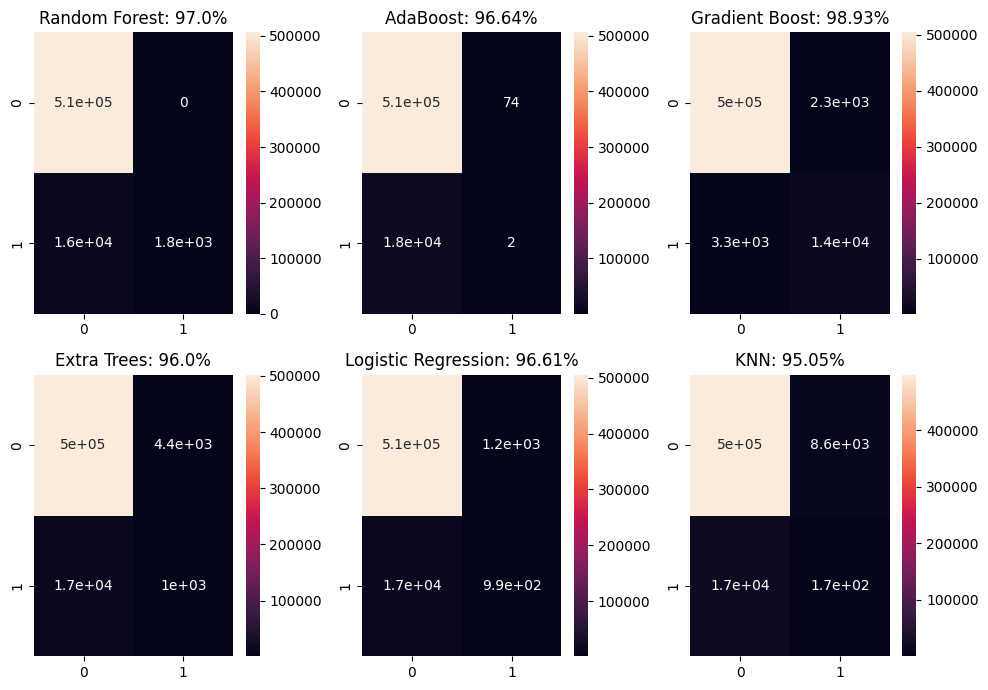

<ipython-input-3-3e998ff1a402>:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(axes.get_xticklabels(), rotation=90)


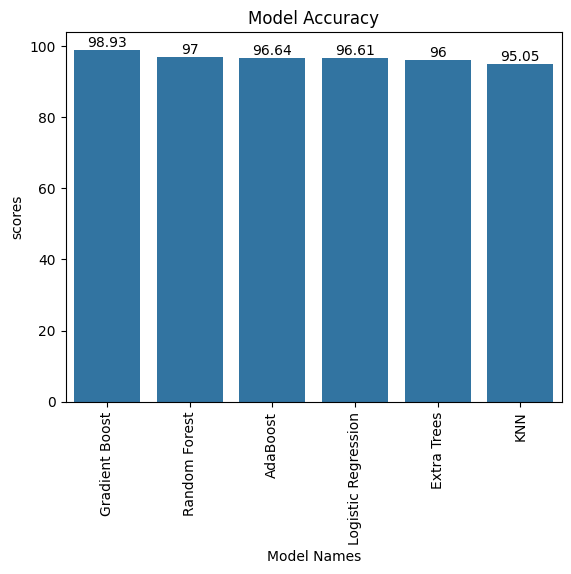

******************************
Gradient Boost
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    506438
           1       0.86      0.81      0.84     17551

    accuracy                           0.99    523989
   macro avg       0.93      0.90      0.92    523989
weighted avg       0.99      0.99      0.99    523989




******************************
Random Forest
              precision    recall  f1-score   support

           0       0.97      1.00      0.98    506438
           1       1.00      0.10      0.19     17551

    accuracy                           0.97    523989
   macro avg       0.98      0.55      0.59    523989
weighted avg       0.97      0.97      0.96    523989




******************************
AdaBoost
              precision    recall  f1-score   support

           0       0.97      1.00      0.98    506438
           1       0.03      0.00      0.00     17551

    accuracy                           0.97  

In [ ]:
predicting_anomaly(X_train_ml, X_test_ml, y_train_llm, y_test_llm, models, model_names)

Row Progress:   0%|          | 0/2 [00:00<?, ?it/s]

Column Progress:   0%|          | 0/3 [00:00<?, ?it/s]

Current Model:  Random Forest
Scoore:  99.48109597720563
Current Model:  AdaBoost
Scoore:  98.92230562091953
Current Model:  Gradient Boost
Scoore:  99.00207828790299


Column Progress:   0%|          | 0/3 [00:00<?, ?it/s]

Current Model:  Extra Trees
Scoore:  99.52747099652855
Current Model:  Logistic Regression


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Scoore:  98.15530478693255
Current Model:  KNN
Scoore:  99.8812952180294


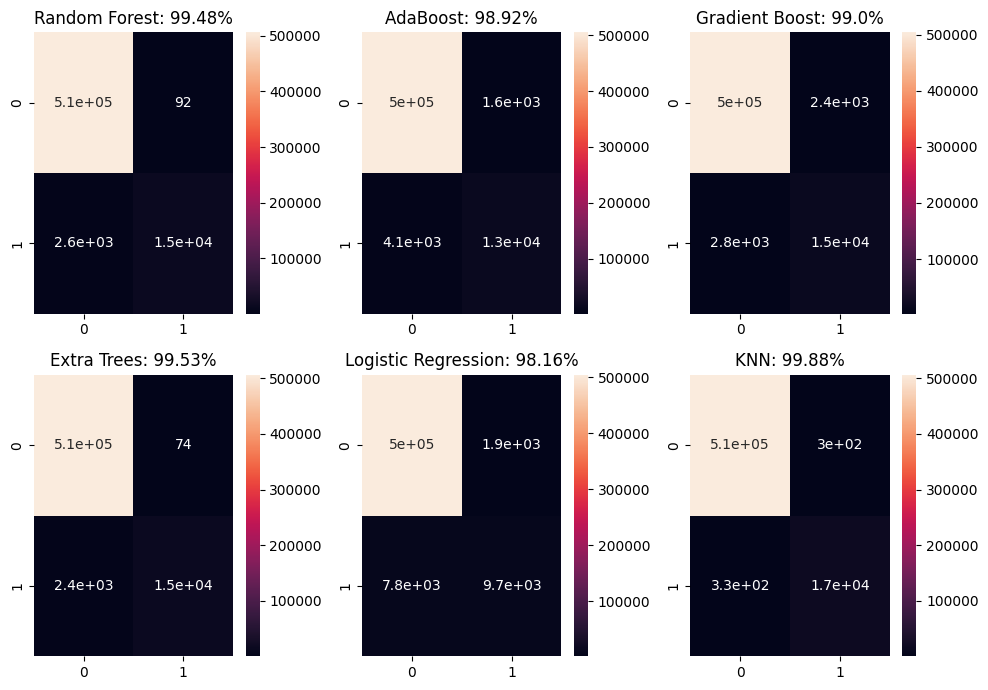

<ipython-input-14-3e998ff1a402>:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(axes.get_xticklabels(), rotation=90)


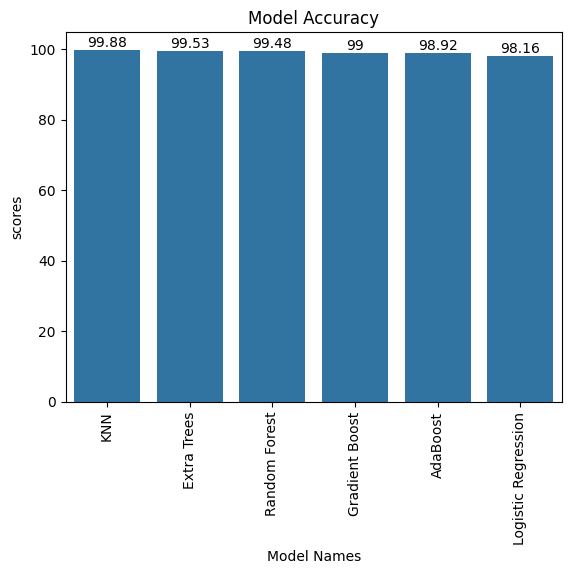

******************************
KNN
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    506514
           1       0.98      0.98      0.98     17475

    accuracy                           1.00    523989
   macro avg       0.99      0.99      0.99    523989
weighted avg       1.00      1.00      1.00    523989




******************************
Extra Trees
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    506514
           1       1.00      0.86      0.92     17475

    accuracy                           1.00    523989
   macro avg       1.00      0.93      0.96    523989
weighted avg       1.00      1.00      1.00    523989




******************************
Random Forest
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    506514
           1       0.99      0.85      0.92     17475

    accuracy                           0.99    523989

In [ ]:
predicting_anomaly(X_train_pca, X_test_pca, y_train_llm, y_test_llm, models, model_names)

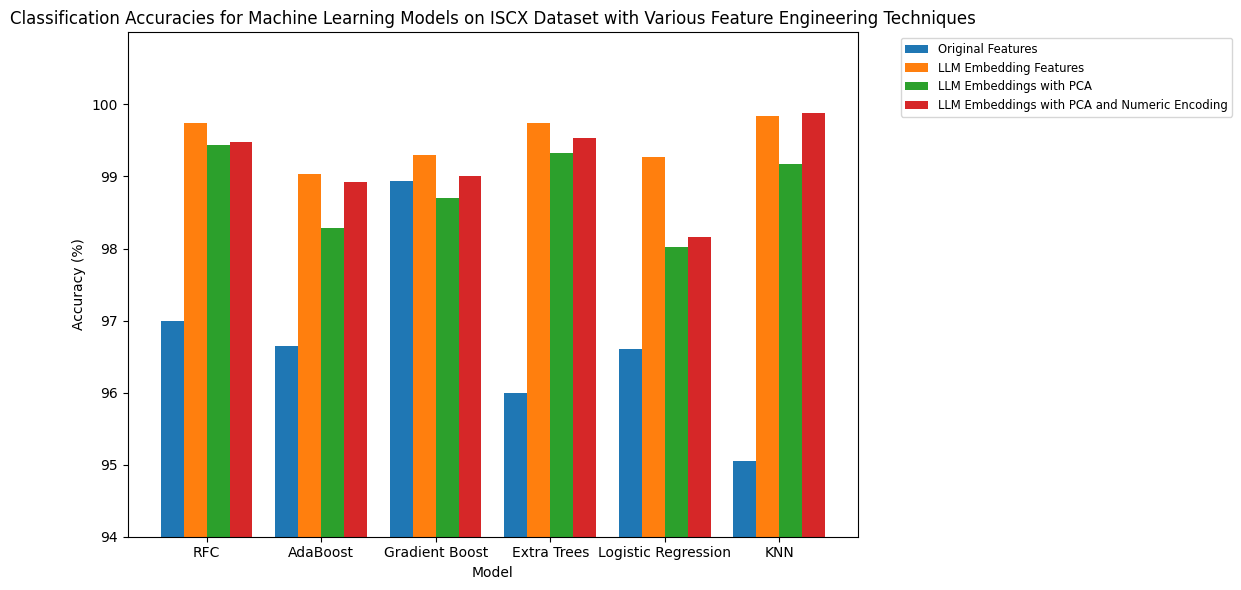

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = ['RFC', 'AdaBoost', 'Gradient Boost', 'Extra Trees', 'Logistic Regression', 'KNN']
without_embeddings = [97.00, 96.64, 98.93, 95.99, 96.61, 95.05]
with_embeddings = [99.74, 99.03, 99.30, 99.74, 99.27, 99.84]
with_embeddings_pca = [99.43, 98.28, 98.70, 99.33, 98.02, 99.17]
with_encode_embeddings_pca = [99.48, 98.92, 99.0, 99.53, 98.16, 99.88]

# Plot configuration
fig, ax = plt.subplots(figsize=(12, 6))

# Bar chart
bar_width = 0.2
index = np.arange(len(models))

bars1 = ax.bar(index, without_embeddings, bar_width, label='Original Features')
bars2 = ax.bar(index + bar_width, with_embeddings, bar_width, label='LLM Embedding Features')
bars3 = ax.bar(index + 2 * bar_width, with_embeddings_pca, bar_width, label='LLM Embeddings with PCA')
bars4 = ax.bar(index + 3 * bar_width, with_encode_embeddings_pca, bar_width, label='LLM Embeddings with PCA and Numeric Encoding')



# Adjusting Y-axis limits and ticks
ax.set_ylim(94, 101)  # Set the new y-axis limits slightly above the max value
ax.set_yticks(np.arange(94, 101, 1))  # Detailed steps from 94.0 to 100.0

# Formatting
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Classification Accuracies for Machine Learning Models on ISCX Dataset with Various Feature Engineering Techniques')
ax.set_xticks(index + 1.5 * bar_width)
ax.set_xticklabels(models)
ax.legend(fontsize='small', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()
